In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
%matplotlib inline

In [4]:
df = pd.read_csv("dataset/A2_data.csv")

In [5]:
# unique classes
print(df['class'].unique())

labels = df['class']
# drop the class column
df = df.drop(['class','field_ID','plate'], axis=1)



['GALAXY' 'QSO' 'STAR']


In [6]:
df.head()

,alpha,delta,u,g,r,i,z,MJD,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,56064,-0.001584
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,53727,-0.824700
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,54883,-0.418000
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,51783,5.953000
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,56069,0.846000


t-SNE

In [7]:
# apply PCA

tsne = TSNE(n_components=2, perplexity=50)
transformed = tsne.fit_transform(df)

c:\Users\KYRIAKOS ARISTIDOU\anaconda3\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\KYRIAKOS ARISTIDOU\anaconda3\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [8]:
transformed_TSNE = pd.DataFrame(transformed, columns=['TSNE1', 'TSNE2'])
key=transformed_TSNE.keys()
transformed_TSNE

,TSNE1,TSNE2
0,4.966379,18.587019
1,30.020636,13.053328
2,42.518753,-9.655818
3,-57.011436,-16.922079
4,15.237863,25.367640
...,...,...
99995,-40.106274,-34.258301
99996,41.820538,40.678566
99997,24.173100,9.273645
99998,15.177093,-32.575218


Random Forest Classifier

In [9]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_TSNE, labels, test_size=0.3, random_state=123, stratify=labels)
clf = RandomForestClassifier()

In [15]:
#scale the data to speed up Random Forest
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train_scaled = scaling.transform(x_train)
x_test_scaled = scaling.transform(x_test)

Hyperparameter Optimisation

In [16]:
#Parameters of RandomForest
pprint(clf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [17]:
#tuning using Random Search
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[None, 1, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                   'criterion': ['gini', 'entropy']}
rf_random = RandomizedSearchCV(clf, hyperparameters, n_iter = 50, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(x_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 5, 10, 15, 20],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=123, verbose=2)

In [18]:
rf_random.best_params_

{'n_estimators': 90,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 15,
 'criterion': 'gini'}

Cross Validation Score

In [17]:
# from sklearn.model_selection import cross_val_score

# cross_score = cross_val_score(clf,features,labels,cv = 5,scoring = "accuracy")
# print(f' Scores for each fold are: {cross_score}')
# print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

Training the RandomForest

In [21]:
clf.set_params(criterion = 'gini', max_features = 'log2', max_depth = 15, min_samples_leaf = 4, min_samples_split = 5, n_estimators = 90)

RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=90)

Test and Evaluation

In [22]:
from sklearn.metrics import accuracy_score, f1_score

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

Train Score is :  0.6002714285714286
Test Score is :  0.5938666666666667
features importances are :  [0.49644801 0.50355199]


In [ ]:
print('features importances are : ' , clf.feature_importances_)

<BarContainer object of 2 artists>

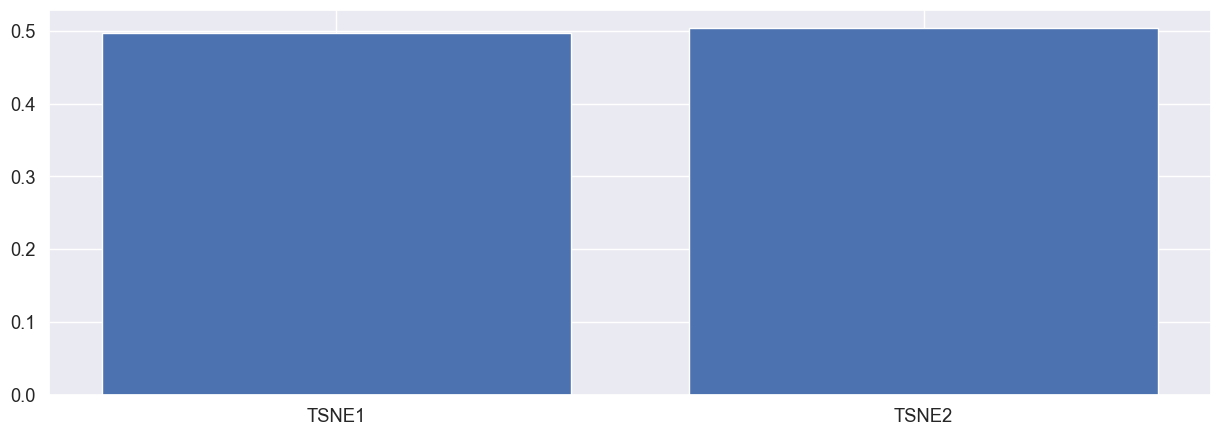

In [23]:
#Visualize feature importance

plt.figure(figsize=(15,5))
plt.bar(key,clf.feature_importances_)

In [24]:
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

Classification report and confusion matrix

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

              precision    recall  f1-score   support

      GALAXY       0.60      1.00      0.75     17834
         QSO       0.20      0.00      0.00      5688
        STAR       0.43      0.01      0.01      6478

    accuracy                           0.59     30000
   macro avg       0.41      0.33      0.25     30000
weighted avg       0.48      0.59      0.45     30000

[[17765    27    42]
 [ 5665     9    14]
 [ 6427     9    42]]


Visualization of Confusion Matrix

Text(43.25, 0.5, 'True')

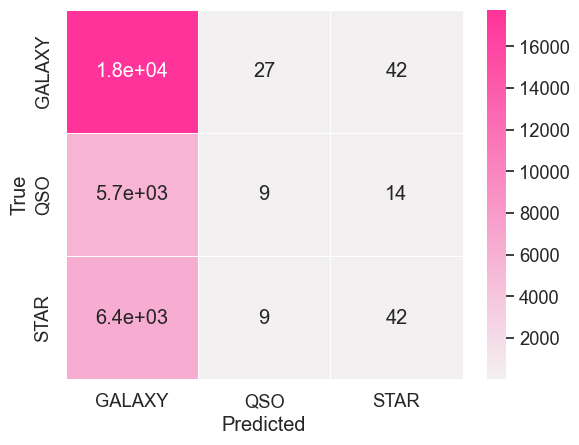

In [26]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')